In [1]:
!pip install -q seaborn

In [2]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential,Model

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# connecting to gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = f"/content/gdrive/MyDrive/ds/"

Mounted at /content/gdrive


**CSM (Conventional and Social Media Movies) Dataset 2014 and 2015 Data Set** [source](https://archive.ics.uci.edu/ml/datasets/CSM+%28Conventional+and+Social+Media+Movies%29+Dataset+2014+and+2015)

12 features categorized as conventional and social media features. Both conventional features, collected from movies databases on Web as well as social media features(YouTube,Twitter).

In [4]:
# reading a specific sheet from the dataset Excel file into pandas dataframe
data = pd.read_excel('/content/gdrive/MyDrive/ds/2014 and 2015 CSM dataset.xlsx', 
                   sheet_name='Sheet1')
# show general info about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Movie                231 non-null    object 
 1   Year                 231 non-null    int64  
 2   Ratings              231 non-null    float64
 3   Genre                231 non-null    int64  
 4   Gross                231 non-null    int64  
 5   Budget               230 non-null    float64
 6   Screens              221 non-null    float64
 7   Sequel               231 non-null    int64  
 8   Sentiment            231 non-null    int64  
 9   Views                231 non-null    int64  
 10  Likes                231 non-null    int64  
 11  Dislikes             231 non-null    int64  
 12  Comments             231 non-null    int64  
 13  Aggregate Followers  196 non-null    float64
dtypes: float64(4), int64(9), object(1)
memory usage: 25.4+ KB


In [5]:
# show first 5 rows of the dataframe
data.head()

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,0,3280543,4632,425,636,1120000.0
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,2,583289,3465,61,186,12350000.0
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,0,304861,328,34,47,483000.0
3,300: Rise of an Empire,2014,6.3,1,106000000,110000000.0,3470.0,2,0,452917,2429,132,590,568000.0
4,A Haunted House 2,2014,4.7,8,17300000,3500000.0,2310.0,2,0,3145573,12163,610,1082,1923800.0


In [6]:
# counting total number of gaps per column
data.isnull().sum()

Movie                   0
Year                    0
Ratings                 0
Genre                   0
Gross                   0
Budget                  1
Screens                10
Sequel                  0
Sentiment               0
Views                   0
Likes                   0
Dislikes                0
Comments                0
Aggregate Followers    35
dtype: int64

In [7]:
# computing the mean of each column with numerical values
means = data.iloc[:, 1:].mean()
# filling gaps with the mean value of each column
data.iloc[:, 1:] = data.iloc[:, 1:].fillna(means)
# checking total number of gaps per column after the filling
data.isnull().sum()

Movie                  0
Year                   0
Ratings                0
Genre                  0
Gross                  0
Budget                 0
Screens                0
Sequel                 0
Sentiment              0
Views                  0
Likes                  0
Dislikes               0
Comments               0
Aggregate Followers    0
dtype: int64

In [8]:
# getting lists of dataset columns by their numerical data type
float_cols = data.select_dtypes(include=['float64']).columns.tolist()
int_cols = data.select_dtypes(include=['int64']).columns.tolist()
print(f"Continuous data columns: {float_cols}")
print(f"Discrete data columns: {int_cols}")

Continuous data columns: ['Ratings', 'Budget', 'Screens', 'Aggregate Followers']
Discrete data columns: ['Year', 'Genre', 'Gross', 'Sequel', 'Sentiment', 'Views', 'Likes', 'Dislikes', 'Comments']


Based on the formed column lists, the Movie title represented by string values is the only one missing. 

As for the original data type of the float columns, all except the Ratings should be converted to the discrete integer type due to their quantitative nature. However, considering the input data normalization, it's not necessary. 

Moreover, the Ratings column is defined as a target variable for the current regression task.  

<Axes: >

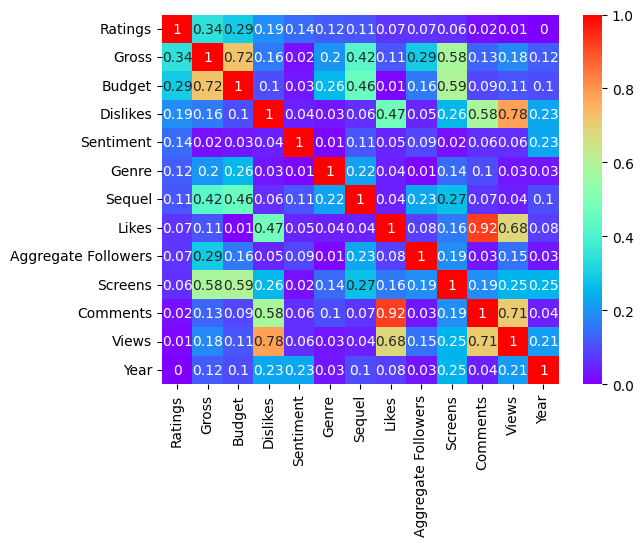

In [9]:
# selecting the target column label
target_col = float_cols.pop(0)
# calculating the correlation strength between the target column and all other 
# columns in the dataframe subset selected for the numerical analysis
tcs = data.corr().abs()[target_col].sort_values(ascending=False)
# reordering columns in the selected dataframe
data_num = data.loc[:, list(tcs.index)]
# creating a heatmap displaying the correlation matrix 
sns.heatmap(data_num.corr().abs().round(2), annot=True, cmap="rainbow")

The Year column isn't associated with the target Ratigns, thus will be excluded from the potential model input factors. 

Furthermore, the Comments and the Views variables form multicollinearity with the Dislikes column, which is more related to the Rating, and should be removed as well. 

The Budget and the Gross are interdependent, so the former is ought to be excluded as less related to the target. 

In [10]:
# removing not relevant for the analysis variables from the selected dataset
data_num.drop(["Views", "Year", "Comments", "Budget"], axis=1, inplace=True)
# show general stats of the relevant numerical feature columns
data_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ratings,231.0,6.441558e+00,9.887652e-01,3.1,5.8,6.5,7.100000e+00,8.7
Gross,231.0,6.806603e+07,8.890289e+07,2470.0,10300000.0,37400000.0,8.935000e+07,643000000.0
Dislikes,231.0,6.790519e+02,1.243929e+03,0.0,105.5,341.0,6.975000e+02,13960.0
Sentiment,231.0,2.809524e+00,6.996775e+00,-38.0,0.0,0.0,5.500000e+00,29.0
Genre,231.0,5.359307e+00,4.141611e+00,1.0,1.0,3.0,8.000000e+00,15.0
Sequel,231.0,1.359307e+00,9.672406e-01,1.0,1.0,1.0,1.000000e+00,7.0
Likes,231.0,1.273254e+04,2.882548e+04,1.0,1776.5,6096.0,1.524750e+04,370552.0
Aggregate Followers,231.0,3.038193e+06,4.499161e+06,1066.0,250000.0,1800000.0,3.038193e+06,31030000.0
Screens,231.0,2.209244e+03,1.431593e+03,2.0,563.5,2757.0,3.334000e+03,4324.0


The Sequel and Genre columns are the only containing categorical data that can be counted. The former is very unbalanced in the number of unique values, since more than 75% is filled with the same integer. 

The Sentiment column representing a view of or attitude toward a movie ranges from negative to positive numbers, thus implies the overall data normalization.

In [11]:
# counting unique values in the genre column
data_num["Genre"].value_counts()

1     65
8     54
3     46
12    13
9     13
10    12
2     12
15    10
6      3
7      2
4      1
Name: Genre, dtype: int64

For some reason, this column has only 11 unique values, while the class indexes range from 1 to 15. 

In [12]:
# remapping genre column labels to the range from 0 to 10
data_num['Genre'] = data_num['Genre'].map({value: i for i, value in 
                                   enumerate(data_num['Genre'].unique())})

In [13]:
# splitting the dataset to train (80%) and test (20%) subset dataframes
train_data = data_num.sample(frac=0.8, random_state=1337)
test_data = data_num.drop(train_data.index)

# splitting the train and test datasets to X factors and y targets 
train_X, train_y = train_data.drop(target_col, axis=1), train_data[target_col].to_numpy()
test_X, test_y = test_data.drop(target_col, axis=1), test_data[target_col].to_numpy()

print(f"Original factor values:\t max {train_X.values.max()} - min {train_X.values.min()}")

# defining a scaler to normalize training data 
scaler = MinMaxScaler()
# defining feature columns set
factor_cols = list(train_X.columns)
# normalizing the data per-column, such that each numerical column of the dataset 
# which could be a potential predictor is scaled to the max absolute value of 1
train_X = scaler.fit_transform(train_X)
# applying the training data normalization parameters to the test dataset
test_X = scaler.transform(test_X)

print(f"Scaled factor values:\t max {round(train_X.max(), 2)} - min {train_X.min()}")

print(f'Training data shape:\t{train_X.shape} - {train_y.shape}')
print(f'Testing data shape:\t{test_X.shape} - {test_y.shape}')

Original factor values:	 max 643000000.0 - min -38.0
Scaled factor values:	 max 1.0 - min 0.0
Training data shape:	(185, 8) - (185,)
Testing data shape:	(46, 8) - (46,)


In [14]:
# defining sequential regression model architecture
def build_model():
  # creating a sequential model, which is a linear stack of layers
  model = keras.Sequential([
    # specifying the input shape based on the number of features in the training data
    layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X.shape[1]]),
    # first two layers have 64 units each and using the ReLU activation function
    layers.Dense(64, activation=tf.nn.relu),
    # last layer returns a single continuous numerical value
    layers.Dense(1)
  ])

  # defining optimizer with a learning rate of 0.001 to minimize the training MSE loss
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  # configuring the model for training by specifying the MSE loss function, 
  # RMSprop optimizer, and two evaluation metrics - MAE and MSE
  model.compile(loss='mean_squared_error', optimizer=optimizer,
      metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [15]:
# initializing a new model instance
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


The total number of layers is 3, input shape is (8,), the output shape is (1)

In [16]:
# defining the dataloader batch size and number of training epochs
batch_size = 32
epochs = 1000

In [17]:
# testing the model
example_batch = train_X[:batch_size]
example_predict = model.predict(example_batch)
example_batch.shape, example_predict.shape

1/1 [==============================] - 1s 555ms/step


((32, 8), (32, 1))

In [18]:
# training the defined model to fit the training data which loaded in batches of
# size 32 during 1000 epochs each finishing with the model accuracy evaluation on 
# the validation dataset (20%), while loss measures the average squared difference 
# between the predicted values and the true values in the batch 
model_train = model.fit(train_X, train_y, batch_size=batch_size, 
                        epochs=epochs, verbose=0, validation_split=0.2)
# forming pandas dataframe on the training stats data
hist_data = pd.DataFrame(model_train.history)
# adding a column of epoch numbers
hist_data['epoch'] = model_train.epoch
# show last 5 rows of the formed dataframe
hist_data.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.288675,0.395360,0.288675,1.183462,0.836437,1.183462,995
996,0.283857,0.405342,0.283857,1.180987,0.835644,1.180987,996
997,0.309816,0.432301,0.309816,1.356930,0.884036,1.356930,997
998,0.288172,0.416017,0.288172,1.163503,0.815721,1.163503,998
999,0.276208,0.391852,0.276208,1.074537,0.837489,1.074537,999


In [19]:
# function to draw accuracy graphs of the models training metrics 
def plot_history(model_train):
  # forming pandas dataframe on the training stats data
  hist = pd.DataFrame(model_train.history)
  # adding a column of epoch numbers
  hist['epoch'] = model_train.epoch

  # drawing graph lines of the recorded model performance metrics
  plt.figure(figsize=(8, 4))
  plt.xlabel('Epoch')
  plt.ylabel(f'Mean Abs Error (MAE) of {target_col}')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train MAE')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val MAE')
  plt.ylim([0, 3])
  plt.legend()

  plt.figure(figsize=(8, 4))
  plt.xlabel('Epoch')
  plt.ylabel(f'Mean Square Error (MSE) of {target_col}')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val MSE')
  plt.ylim([0, 5])
  plt.legend()
  plt.show()

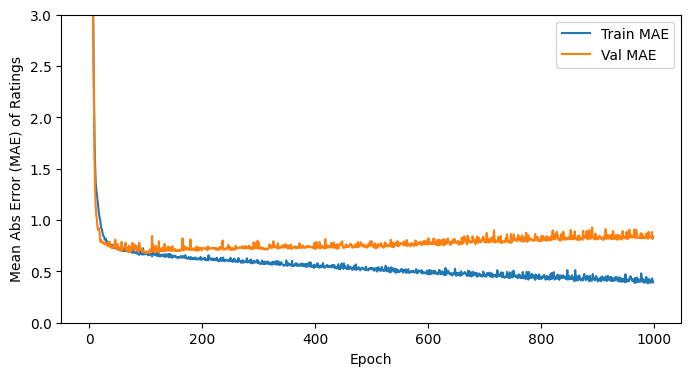

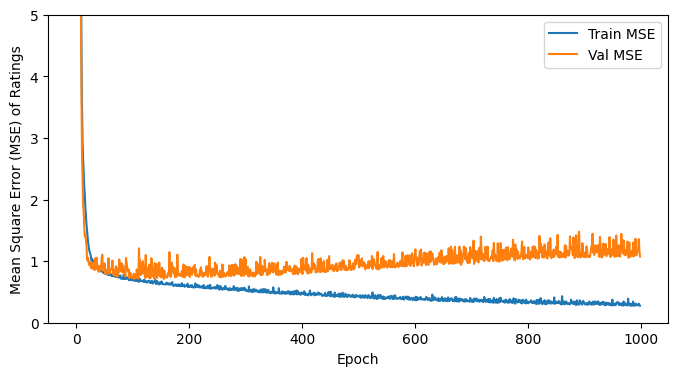

In [20]:
# drawing performance metrics graphs for the trained model
plot_history(model_train)

Validation MSE and MAE have been growing since epoch 50, the initial number of epochs was overestimated. 

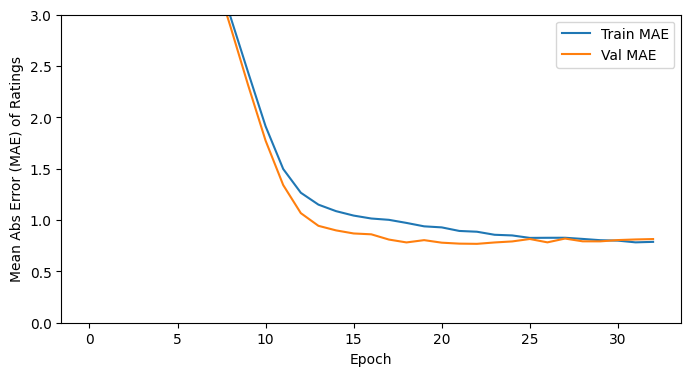

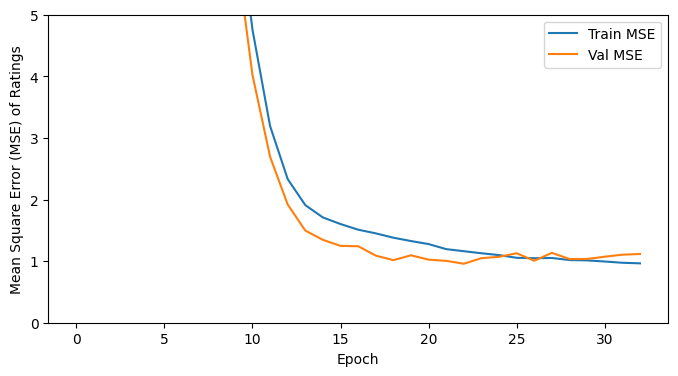

In [21]:
# initializing new model instance of the same architecture
model = build_model()
# setting patience parameter as the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# training the defined model in the similar setting 
model_train = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, 
                        verbose=0, validation_split=0.2, callbacks=[early_stop])
# drawing performance metrics graphs for the trained model
plot_history(model_train)

After the 30th epoch the model was losing its generalization capability due to the data overfitting. 

In [22]:
# evaluating the model on the previously unseen test dataset
test_eval = model.evaluate(test_X, test_y, verbose=0)
print(f'Test loss:\t{test_eval[0]}')
print(f'Test MAE:\t{test_eval[1]}')
print(f'Test MSE:\t{test_eval[2]}')

Test loss:	0.8205345273017883
Test MAE:	0.6387553215026855
Test MSE:	0.8205345273017883


In [23]:
# predicting the Rating for the test dataset inputs using the trained model
test_predicts = model.predict(test_X).flatten()
# calculating errors for the predicted values
error = test_predicts - test_y

test_predicts.shape, test_y.shape, error.shape

2/2 [==============================] - 0s 4ms/step


((46,), (46,), (46,))

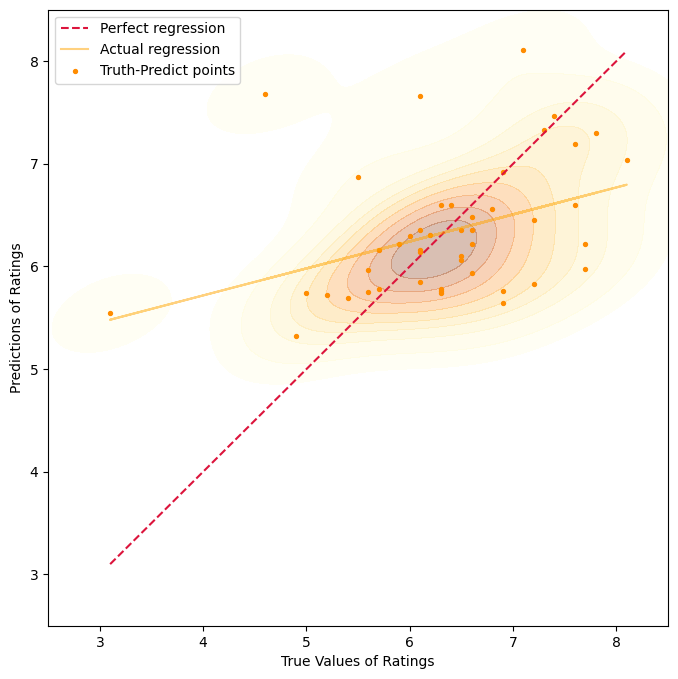

In [24]:
plt.figure(figsize=(8, 8))
# drawing the perfect regression line in red
steps = np.linspace(test_y.min(), test_y.max(), 100)
plt.plot(steps, steps, linestyle='dashed', color="crimson", label="Perfect regression")
# drawing the actual regression line in gold
slope, intercept = np.polyfit(test_y, test_predicts, 1)
plt.plot(test_y, slope * test_y + intercept, color='orange', alpha=0.5, label="Actual regression")
# drawing data kernel density estimation lines 
sns.kdeplot(x=test_y, y=test_predicts, fill=True,
            cmap=sns.color_palette("YlOrBr", as_cmap=True), alpha=0.3)
# drawing scatter plot of the true and predicted values
plt.scatter(test_y, test_predicts, color="darkorange", s=8, label="Truth-Predict points")
plt.xlabel(f'True Values of {target_col}')
plt.ylabel(f'Predictions of {target_col}')
plt.ylim([2.5, 8.5])
plt.xlim([2.5, 8.5])
plt.legend()
plt.show()

Considering the size of the initial dataset, the regression model demonstrates good enough results. 

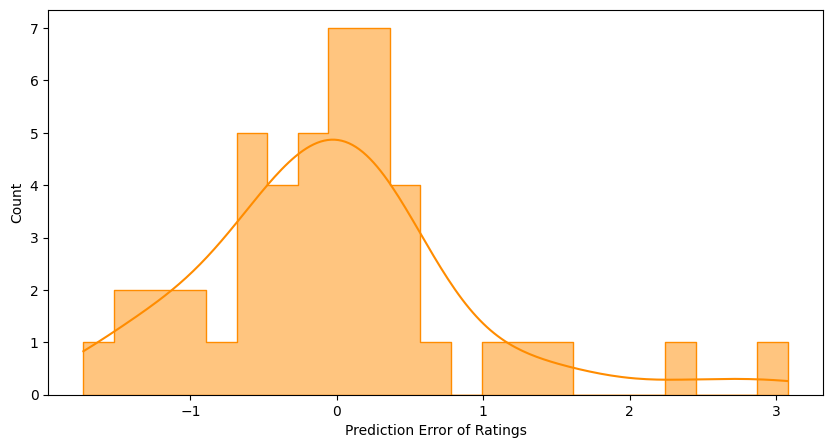

In [25]:
# drawing histogram of prediction error distribution
plt.figure(figsize=(10, 5))
sns.histplot(error, kde=True, bins=23, color="darkorange", element="step")
plt.xlabel(f'Prediction Error of {target_col}')
plt.ylabel("Count")
plt.show()